In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt2",          # --job-name
    cores=2,                     # Number of cores per task (adjust if needed)
    processes=1,                 # One process per task
    memory="20GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

import glob 
import os

In [2]:
data_dir = '/home1/nalex2023/Datasets/interpsonde_manus/*.nc'

all_dsets = glob.glob(data_dir)

all_dsets

['/home1/nalex2023/Datasets/interpsonde_manus/2009_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2002_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2003_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2008_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2014_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2001_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2004_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2013_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2012_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2005_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2010_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2007_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2006_MANUS_INTERPSONDEv2.nc',
 '/home1/nal

In [3]:
from dask.distributed import Client
cluster.scale(jobs=4)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:42233,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [86]:
import xarray as xr 
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

dset = xr.open_mfdataset(all_dsets, combine='by_coords').sel(time=slice('2011'))
dset['height'] = dset['height'] * 1000
dset['time'] = dset['time'].roll(time=10)

dset = dset.sortby('time')


In [87]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from windrose import WindroseAxes


def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')


    return dft

In [88]:
#dset['u_wind'] = dset['u_wind'] - dset['u_wind'].mean(dim='time')
#dset['v_wind'] = dset['v_wind'] - dset['v_wind'].mean(dim='time')
dset

<xarray.Dataset> Size: 735MB
Dimensions:   (time: 92136, height: 332)
Coordinates:
  * height    (height) float32 1kB 4.0 24.0 44.0 ... 3.95e+04 4e+04 4.05e+04
  * time      (time) datetime64[ns] 737kB 2001-04-05 ... 2011-12-31T23:00:00
Data variables:
    bar_pres  (time, height) float32 122MB dask.array<chunksize=(8376, 332), meta=np.ndarray>
    temp      (time, height) float32 122MB dask.array<chunksize=(8376, 332), meta=np.ndarray>
    dp        (time, height) float32 122MB dask.array<chunksize=(8376, 332), meta=np.ndarray>
    rh        (time, height) float32 122MB dask.array<chunksize=(8376, 332), meta=np.ndarray>
    u_wind    (time, height) float32 122MB dask.array<chunksize=(8376, 332), meta=np.ndarray>
    v_wind    (time, height) float32 122MB dask.array<chunksize=(8376, 332), meta=np.ndarray>
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

In [89]:
dset['angle'] = (90 - np.degrees(np.arctan2(-dset['u_wind'], -dset['v_wind']))) % 360



dset['speed'] = np.sqrt((dset['u_wind'] * dset['u_wind']) + 
                        (dset['v_wind'] * dset['v_wind']))

# remove the wind direction and speed if both u and v are 0
dset['angle'] = dset['angle'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['angle'])

dset['speed'] = dset['speed'].where((dset['u_wind'] == 0) & (dset['v_wind'] == 0), dset['speed'])



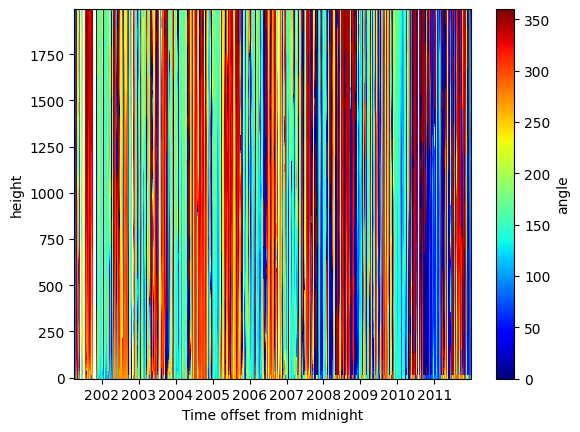

In [90]:
dset['angle'].sel(height=slice(0,2000)).plot(x='time',
                                          cmap='jet')

In [91]:
def draw_windrose(data,color=cm.Blues):
    ws = data['speed'].values
    wd = data['angle'].values
    ax = WindroseAxes.from_ax()
    ax.bar(wd,ws,normed=False,cmap=color)
    ax.set_legend()


def wind_rose_compare(data1,data2 ,cost_angle):
    ws1 = data1['speed'].values
    wd1 = data1['angle'].values
    ws2 = data2['speed'].values
    wd2 = data2['angle'].values
    
    ax = WindroseAxes.from_ax()
    
    ax.bar(wd1,ws1,normed=False,cmap=cm.Reds)
    ax.set_legend(loc='lower right')
    ax.bar(wd2,ws2,normed=False,cmap=cm.Blues)
    ax.set_legend(loc='lower left')

In [92]:
a  = dset.sel(height=10,method='nearest').compute()#.sel(hour=slice(12,19))
b = dset.sel(height=slice(200,900)).mean(dim='height').compute()#.sel(hour=slice(12,19))

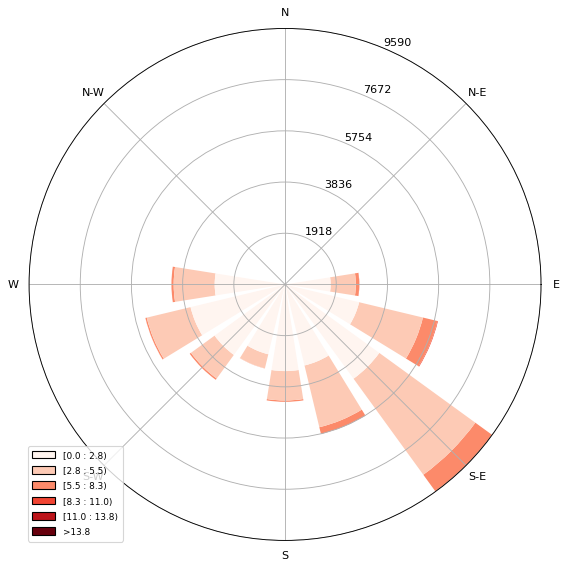

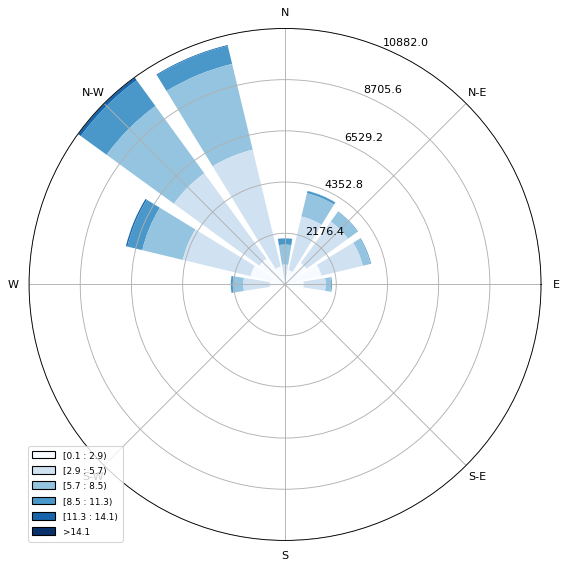

In [93]:
cost_angle = 0


def ang_diff(angle1, angle2):
    diff = np.abs(angle1 - angle2)
    if diff > 180:
        diff = 360 - diff
    return diff



diff_a_coast = xr.apply_ufunc(
    ang_diff,
    a['angle'],
    cost_angle,
    input_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64],
)


diff_b_coast = xr.apply_ufunc(
    ang_diff,
    b['angle'],
    cost_angle + 180,
    input_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.float64],
)


a_within_90 = a.where(diff_a_coast > 90, drop=True)
b_within_180 = b.where(diff_b_coast > 90, drop=True)


draw_windrose(a_within_90,color=cm.Reds)
draw_windrose(b_within_180,color=cm.Blues)





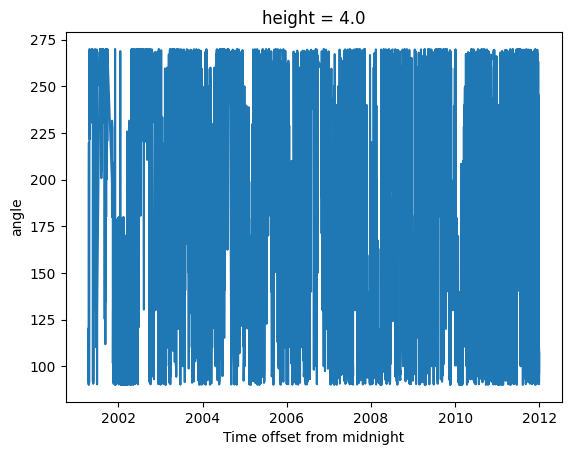

In [94]:
a_within_90['angle'].plot()

In [95]:
SBI = np.cos(np.radians(a_within_90['angle'] - cost_angle)) * np.cos(a_within_90['angle'] + 180 - b_within_180['angle'])

SBI_diurnal = SBI.groupby('time.hour').sum(dim='time').compute()

In [96]:
SBI_diurnal = SBI[SBI > 0].groupby('time.hour').mean(dim='time').compute()



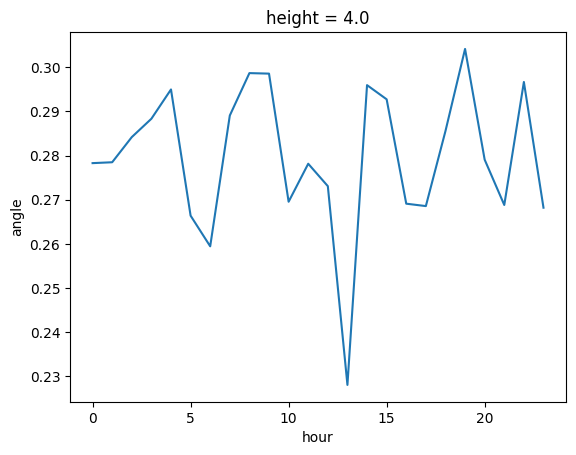

In [97]:
SBI_diurnal.plot()

In [98]:
met_fol = '/home1/nalex2023/Datasets/met_manus/'

met_dft = create_dft(met_fol,arm_data=True)

#met_dft_2012 = met_dft[met_dft['datetime'].dt.month.isin([4,5,6])][met_dft['datetime'].dt.year == 2012]

met_dft_2012 = met_dft[met_dft['datetime'].dt.year == 2011]

met_dft_2012

,filepath,filename,datetime
6,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20110718.000000.cdf,2011-07-18
24,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20111108.000000.cdf,2011-11-08
42,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20110114.000000.cdf,2011-01-14
51,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20110325.000000.cdf,2011-03-25
90,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20110529.000000.cdf,2011-05-29
...,...,...,...
6016,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20110423.000000.cdf,2011-04-23
6027,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20110604.000000.cdf,2011-06-04
6057,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20111002.000000.cdf,2011-10-02
6087,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20110612.000000.cdf,2011-06-12


In [99]:


dset_met_manus = xr.open_mfdataset(met_dft_2012['filepath'].values, combine='by_coords',chunks='auto')

In [100]:
surface_temp = dset_met_manus['temp_mean'].resample(time='1h').mean().roll(time=10)

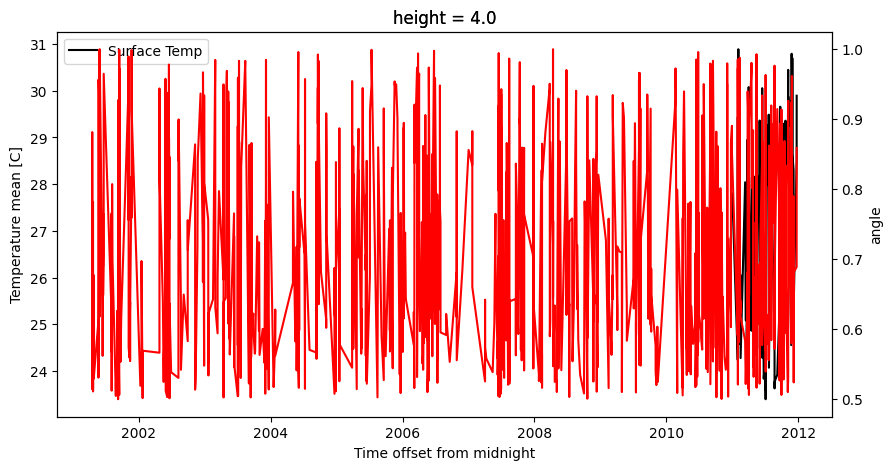

In [102]:
SBI_high = SBI.where(SBI > 0.5, drop=True)

time_highs = SBI_high.time

#temp_surface = dset['temp'].sel(height=2,method='nearest').sel(time=time_highs).compute()
temp_surface = surface_temp.sel(time=time_highs,method='nearest').compute()

fig,ax = plt.subplots(1,1,figsize=(10,5))

temp_surface.plot(ax=ax, color='black', label='Surface Temp')

ax2 = ax.twinx()

SBI_high.plot(ax=ax2, color='red', label='SBI > 0.8')

ax.legend(loc='upper left')

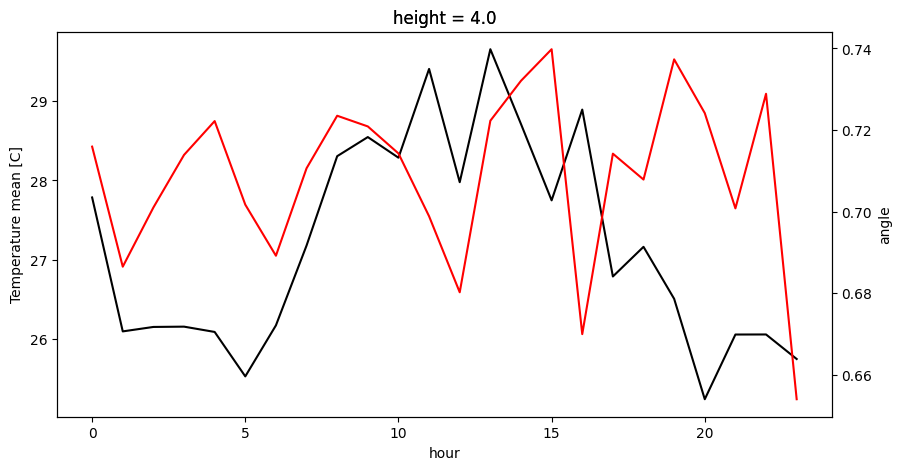

In [103]:
diurnal_surf_temp = temp_surface.groupby('time.hour').mean(dim='time').compute()

diurnal_sbi = SBI_high.groupby('time.hour').mean(dim='time').compute()


fig,ax = plt.subplots(1,1,figsize=(10,5))

ax2 = ax.twinx()

diurnal_surf_temp.plot(ax=ax, color='black', label='Surface Temp')

diurnal_sbi.plot(ax=ax2, color='red', label='SBI > 0.8')


new_dft = SBI_diurnal.to_dataframe().reset_index()


In [105]:
new_dft_diurnal = new_dft.set_index('hour')

temp_dft = diurnal_surf_temp.to_dataframe().reset_index().set_index('hour')

new_dft_diurnal['temp'] = temp_dft['temp_mean']

final_cols = new_dft_diurnal.drop(columns=['height'])

final_cols

,angle,temp
hour,,
0,0.278290,27.784508
1,0.278489,26.091936
2,0.284191,26.148191
3,0.288355,26.151924
4,0.294998,26.085001
5,0.266380,25.523439
6,0.259427,26.168119
7,0.289086,27.176889
8,0.298703,28.306122


In [ ]:
# lead lag correlation 

